In [75]:
import numpy as np
#continuous intervals
first = 1
last = 100

In [76]:
def continuous(first, last):
	domain = np.arange(0, 100, 1)
	i = 1
	n = last*(last + 1)/2
	hyps = []
	names = []
	sizes = []
	for s in domain:
		local_domain = np.arange(s, last, 1)
		for e in local_domain:
			hyps.append(np.arange(s, e+1,1))
			names.append(["interval from " + str(s) + " to " + str(e)])
			sizes.append(len(hyps[i-1]))
			i = i + 1
	return [hyps, names, sizes]

In [77]:
# all number
def all_number(first, last):
	all =  np.arange(0, 100, 1)
	names = "all"
	sizes = len(all)
	return [all, names, sizes]

In [78]:
# even or odd
def even_odd(first, last):
	domain = np.arange(0, 100, 1)
	evens = [x for x in domain if x % 2 == 0]
	odds = [x for x in domain if x % 2 != 0]
	hyps = np.array((evens, odds))
	names = ["evens", "odds"]
	sizes = [len(evens), len(odds)]
	return [hyps, names, sizes]

In [79]:
# powers
def powers (first, last):
	domain = np.arange(0, 100, 1)
	power = [2, 3, 4, 5, 6]
	n = len(power)
	hyps = []
	names = []
	sizes = []
	for i in np.arange(1, n, 1):
		p = power[i-1]
		hyps.append([n**p for n in domain if n**p<=last])
		names.append(["powers of " + str(p)])
		sizes.append(len(hyps[i-1]))
	return [hyps, names, sizes]

In [83]:
# a chart of all lower hypothesis
def hypothesis_chart(first, last):
	c=continuous(first, last)
	n=all_number(first, last)
	eo=even_odd(first, last)
	p=powers(first, last)
	return [c, n, eo, p, n]

In [84]:
# lower hypothesis space
###### mag first, math second ######
c=continuous(first, last)
n=all_number(first, last)
eo=even_odd(first, last)
p=powers(first, last)
n_2=all_number(first, last)
nmag = len(c[0]) + len(n[0])
nmath = len(eo[0]) + len(p[0]) + len(n_2[0])
hypothesis_space=[]
hypothesis_space.extend(c[0])
hypothesis_space.extend(n[0])
hypothesis_space.extend(eo[0])
hypothesis_space.extend(p[0])
hypothesis_space.extend(n_2[0])

In [85]:
# covert lower hypothesis space to binary
last = 100
nhyp = len(hypothesis_space)
print (nhyp)
hypothesisbin = np.zeros(shape = [last, nhyp])

5256


In [86]:
# overhypothesis space
##### mag first, math second ######
mag_space = np.append(np.repeat(1, nmath), np.repeat(0, nmag))
math_space = np.append(np.repeat(0, nmath), np.repeat(1, nmag))
overhypothesis = np.stack((mag_space, math_space))

In [87]:
# lambda
math_prior = 0.9
# 1-lambda
mag_prior = 1-math_prior

In [88]:
### prior ###

##### mag first, math second ######

# low-level prior
prior_mag = mag_prior/nmag
prior_math = math_prior/nmath
low_prior = []
low_prior.extend(np.repeat(prior_mag, nmag))
low_prior.extend(np.repeat(prior_math, nmath))
low_prior = np.matrix(low_prior)


In [89]:
# theory level prior
##### mag first, math second ######
theory_prior = np.matrix((mag_prior, math_prior))
print (theory_prior[0,1])

print (theory_prior.shape)

0.9
(1, 2)


In [90]:
# lower-level matrix
domain = np.arange(0, 100, 1)
print (len(domain))
lower_level_matrix = np.empty(shape=[0, nhyp])
for d in domain:
	d_binary = []
	for h in hypothesis_space:
		if np.in1d(d, h)[0]:
			d_binary.append(1)
		else:
			d_binary.append(0)
	lower_level_matrix = np.append(lower_level_matrix, [d_binary], axis = 0)
print (lower_level_matrix)

100
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [91]:
# lower_level likelihood
lower_level_likelihood_deno = np.sum(lower_level_matrix, axis = 0)
lower_level_likelihood = np.matrix([1/p for p in lower_level_likelihood_deno])

In [92]:
# lower_level likelihood of an observation
def lower_level_likelihood_for_observation(lower_level_matrix, observation):
    lower_level_likelihood_observation = np.multiply(lower_level_matrix[observation,:], lower_level_likelihood)
    return lower_level_likelihood_observation
#observation = 2
#lower_level_likelihood_observation = np.multiply(lower_level_matrix[observation,:], lower_level_likelihood)

In [93]:
### Step 1 - theory-level likelihood ###
def theory_level_likeli(overhypothesis, low_prior):
    theory_level_likelihood_mag=np.multiply(np.matrix(overhypothesis[0,:]).transpose(),low_prior.transpose())
    theory_level_likelihood_mag /= np.sum(theory_level_likelihood_mag)
    theory_level_likelihood_math=np.multiply(np.matrix(overhypothesis[1,:]).transpose(),low_prior.transpose())
    theory_level_likelihood_math /= np.sum(theory_level_likelihood_math)
    theory_level_likelihood = np.stack((theory_level_likelihood_mag.transpose(), theory_level_likelihood_math.transpose()))
    return theory_level_likelihood

In [94]:
### Step 2 ###
def prob_observation_for_theory (lower_level_likelihood_observation, theory_level_likelihood):
    # prior for observation
    #prob_observation_theory = transpose_lower_likeli*theory_level_likelihood
    prob_observation_theory = []
    for row in theory_level_likelihood:
        a = np.multiply(row, lower_level_likelihood_observation)
        prob_observation_theory.append(np.sum(a))
    prob_observation_theory = np.matrix(prob_observation_theory)
    return prob_observation_theory

In [95]:
### Step 3 theory-level posterior distribution ###
def theory_level_posterior_distribution(prob_observation_theory, theory_prior):
    numerator = np.multiply(prob_observation_theory, theory_prior)
    denominator = np.sum(numerator)
    theory_level_posterior = numerator/denominator
    return theory_level_posterior

In [96]:
### Step 3a lower-level posterior distribution ###
def low_level_posterior_distribution(low_prior, lower_level_likelihood_observation):
    numerator = np.multiply(low_prior, lower_level_likelihood_observation)
    denominator = np.sum(numerator)
    i = 0
    lower_level_posterior = []
    while i < nhyp:
        lower_level_posterior.append(numerator[0,i]/denominator)
        i = i +1
    lower_level_posterior = np.matrix(lower_level_posterior)
    return lower_level_posterior

In [97]:
### Step 4 re-assigning priors ###
def assign_theory_priors(theory_level_posterior, lower_level_posterior):
    math_prior = theory_level_posterior[0,1]
    mag_prior = 1 - math_prior
    new_theory_prior = np.matrix((mag_prior, math_prior))
    return new_theory_prior
def assign_low_priors(lower_level_posterior, new_theory_prior):
    # low level #
    mag_prior = new_theory_prior[0, 0]
    math_prior = new_theory_prior[0 ,1]
    denominator = np.sum(lower_level_posterior)
    numerator = []
    i = 0
    while i < nmag:
        numerator.append(mag_prior*lower_level_posterior[0, i])
        i = i + 1
    m = nmag
    while m < (nhyp):
        numerator.append(math_prior * lower_level_posterior[0, m])
        m = m + 1
    
    lower_level_new_prior = np.matrix([n/denominator for n in numerator])
    return lower_level_new_prior

In [98]:
observation_list = [2, 4, 6, 8]
# lambda
math_prior = 0.5
# 1-lambda
mag_prior = 1-math_prior
theory_prior = [mag_prior, math_prior]

def run_the_model(observation_list, math_prior, low_prior, theory_prior):
    posterior_predictive = []
    for o in observation_list:
        lower_level_likelihood_observation = lower_level_likelihood_for_observation(lower_level_matrix, o)
        theory_level_likelihood = theory_level_likeli(overhypothesis, low_prior)
        prob_observation_theory = prob_observation_for_theory (lower_level_likelihood_observation, theory_level_likelihood)
        theory_level_posterior = theory_level_posterior_distribution(prob_observation_theory, theory_prior)
        print(theory_level_posterior)
        lower_level_posterior = low_level_posterior_distribution(low_prior, lower_level_likelihood_observation)
        posterior_predictive_o = lower_level_matrix*lower_level_posterior.transpose()
        theory_prior = theory_level_posterior.copy()
#         print(theory_prior)
        low_prior = lower_level_posterior.copy()
        posterior_predictive.append(posterior_predictive_o)
    return posterior_predictive 

In [99]:
posterior = run_the_model(observation_list, math_prior, low_prior, theory_prior)

[[ 0.8455731  0.1544269]]
[[ 0.99577293  0.00422707]]
[[ 0.99503349  0.00496651]]
[[ 0.99220469  0.00779531]]


(100, 1)


<function matplotlib.pyplot.show>

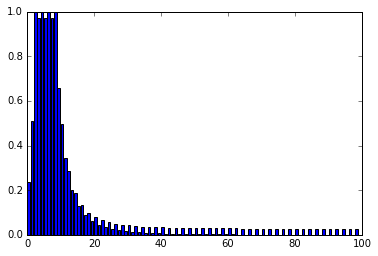

In [100]:
%matplotlib inline
x_axis = domain = np.arange(0, 100, 1)
y_axis = posterior[3]
print(y_axis.shape)
plt.bar(x_axis, y_axis)
plt.show